<a href="https://colab.research.google.com/github/skyprince999/100-Days-Of-ML/blob/master/Day_15_Class_Activations_in_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Class Activation Mapping in PyTorch: [Link](https://snappishproductions.com/blog/2018/01/03/class-activation-mapping-in-pytorch.html.html)

In [0]:
%matplotlib inline

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import numpy as np
import skimage.transform

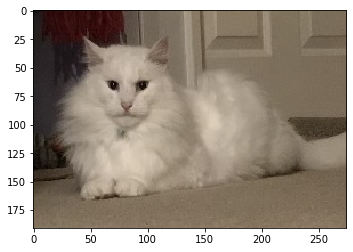

In [3]:
image = Image.open("cam_1.jpg")
imshow(image)

In [0]:
# Imagenet mean/std

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

# Preprocessing - scale to 224x224 for model, convert to tensor, 
# and normalize to -1..1 with mean/std for ImageNet

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

display_transform = transforms.Compose([
   transforms.Resize((224,224))])

In [13]:
tensor = preprocess(image) # Preprocess image to Imagenet normalization 
tensor.shape

torch.Size([3, 224, 224])

In [14]:
prediction_var = Variable((tensor.unsqueeze(0)).cuda(), requires_grad=True) # Squeeze the  variable to add an additional dimension & then
prediction_var.shape                                                        # wrap it in a Variable which stores the grad_training weights  

torch.Size([1, 3, 224, 224])

In [0]:
model = models.resnet18(pretrained=True) # load a base model & make it ready for evaluations
model.cuda()
model.eval();

This creates a call back hook to the model. 
It will grab the final layer of the model and save the activation features as an instance variable 

In [0]:
class SaveFeatures(): 
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

In [0]:
final_layer = model._modules.get('layer4') # Grab the final layer of the model 

In [0]:
activated_features = SaveFeatures(final_layer) # attach the call back hook to the final layer of the model 

In [20]:
prediction = model(prediction_var)    # Pass the variable through the trained model 
pred_probabilities = F.softmax(prediction).data.squeeze() # Pass the predictions through a softmax layer to convert into probabilities for each class
activated_features.remove() # What does this do ?? 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [21]:
# To check for the top k predictions we get:
topk(pred_probabilities,3)   # indice 283 >>> is for persian cat 

torch.return_types.topk(values=tensor([0.6899, 0.2530, 0.0092], device='cuda:0'), indices=tensor([283, 332, 285], device='cuda:0'))

In [0]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

In [25]:
weight_softmax_params = list(model._modules.get('fc').parameters()) # This gives a list of weights for the fully connected layers 
len(weight_softmax_params) 

2

In [28]:
weight_softmax_params[0].shape, weight_softmax_params[1].shape # weghts for the last two layers

(torch.Size([1000, 512]), torch.Size([1000]))

In [29]:
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy()) # what does this do ??
weight_softmax.shape

(1000, 512)

In [30]:
class_idx = topk(pred_probabilities,1)[1].int() # get the class index (persian cat )
class_idx

tensor([283], device='cuda:0', dtype=torch.int32)

In [0]:
overlay = getCAM(activated_features.features, weight_softmax, class_idx )

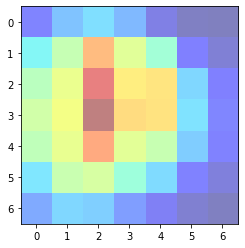

In [32]:
imshow(overlay[0], alpha=0.5, cmap='jet')

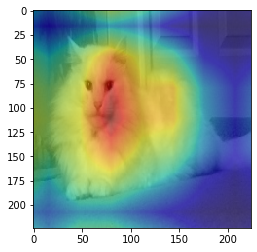

In [33]:
imshow(display_transform(image)) # the heatmap is around the face of the cat
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');

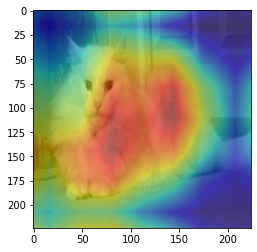

In [34]:
class_idx = topk(pred_probabilities,2)[1].int() # This gives 332 -->> which is a Angora Rabbit 
overlay = getCAM(activated_features.features, weight_softmax, 332 )

imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet'); # the heatmap is high on the fur of the cat